In [1]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

In [2]:
X = np.random.normal(0.0, 1, (1000, 2))
A = np.array([[1,2], [-0.1, 0.5]])
b = np.array([1,2])
data = np.dot(X, A) + b

Kovaryans matrisi 
[[1.01 1.95]
 [1.95 4.25]]


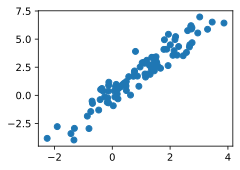

In [3]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].asnumpy(), data[:100, (1)].asnumpy())
print(f'Kovaryans matrisi \n{np.dot(A.T, A)}')

In [4]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

In [5]:
#Generator, tek katmanlı bir lineer model
net_G = nn.Sequential()
net_G.add(nn.Dense(2))

In [6]:
#Discriminator, 3 katmanlı bir MLP
net_D = nn.Sequential()
net_D.add(nn.Dense(5, activation = 'tanh'),
          nn.Dense(3, activation = 'tanh'),
          nn.Dense(1))

In [7]:
#Training (Eğitim)
def update_G(Z, net_D, net_G, loss, trainer_G):
    batch_size = Z.shape[0]
    ones = np.ones((batch_size,), ctx = Z.ctx)
    with autograd.record():
        fake_X = net_G(Z)
        fake_Y = net_D(fake_X)
        loss_G = loss(fake_Y, ones)
    loss_G.backward()
    trainer_G.step(batch_size)
    return float(loss_G.sum())

In [8]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    batch_size = Z.shape[0]
    ones = np.ones((batch_size,), ctx = Z.ctx)
    zeros = np.zeros((batch_size,), ctx = Z.ctx)
    with autograd.record():
        real_Y = net_D(X)
        fake_X = net_G(Z)
        fake_Y = net_D(fake_X.detach())
        loss_D = (loss(real_Y, ones) + loss(fake_Y, zeros)) / 2
    loss_D.backward()
    trainer_D.step(batch_size)
    return float(loss_D.sum())

In [13]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = gluon.loss.SigmoidBCELoss()
    net_D.initialize(init=init.Normal(0.02), force_reinit=True)
    net_G.initialize(init=init.Normal(0.02), force_reinit=True)
    trainer_D = gluon.Trainer(net_D.collect_params(),'adam', {'learning_rate': lr_D})
    trainer_G = gluon.Trainer(net_G.collect_params(),'adam', {'learning_rate': lr_G})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[1, num_epochs], nrows=2, figsize=(5, 5),legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
    # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples
        for X in data_iter:
            batch_size = X.shape[0]
            Z = np.random.normal(0, 1, size=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),update_G(Z, net_D, net_G, loss, trainer_G),batch_size)
        # Visualize generated examples
        Z = np.random.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).asnumpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
        print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, 'f'{metric[2] / timer.stop():.1f} examples/sec')
    

loss_D 0.693, loss_G 0.693, 465.9 examples/sec


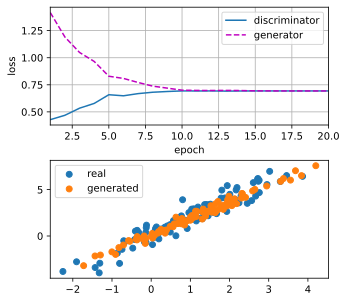

In [15]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data[:100].asnumpy())